## Illustration of good, bad and useless practices when collinearity is encountered

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [ ]:
def vif_desmtx(desmtx):
    vif = pd.DataFrame()
    vif['VIF'] = [
        variance_inflation_factor(desmtx.values, i)
        for i in range(desmtx.shape[1])
    ]
    vif['features'] = desmtx.columns
    return vif

In [ ]:
def est_vif_add_desmat_labels(desmat):
    vifs = vif_desmtx(desmat)
    vif_subset = (
        vifs[~vifs['features'].isin(['constant'])].set_index('features').T
    )
    design_labels_with_vif = {
        label: f'{label}\nVIF={vif:.2f}'
        for label, vif in zip(vif_subset.columns, vif_subset.values[0])
    }
    desmat_vif_labels = desmat.rename(columns=design_labels_with_vif)
    return desmat_vif_labels

In [ ]:
def make_desplot_corplot(
    desmat_left, desmat_right, name_left, name_right, figure_path=None
):
    designs = {name_left: desmat_left, name_right: desmat_right}

    design_mats = {}
    cor_mats = {}
    for key, desmat in designs.items():
        design_mats[key] = est_vif_add_desmat_labels(desmat)
        cor_mats[key] = design_mats[key].drop(columns=['constant']).corr()

    fig, axes = plt.subplots(2, 2, figsize=(8, 10))

    for i, name in enumerate(designs.keys()):
        plot_design_matrix(design_mats[name], ax=axes[0, i])
        axes[0, i].set_title(name)
        sns.heatmap(
            cor_mats[name],
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            cbar=False,
            ax=axes[1, i],
            square=True,
        )
        axes[1, i].set_title('Correlation')
        axes[1, i].tick_params(axis='x', rotation=90)
        axes[1, i].tick_params(axis='y', rotation=0)
    plt.tight_layout()
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path)
    plt.show()

In [ ]:
def make_step_desplot(
    desmat_left,
    desmat_right,
    name_left,
    name_right,
    frame_times,
    figure_path=None,
    conv=False,
):
    designs = {name_left: desmat_left, name_right: desmat_right}
    fig, axes = plt.subplots(1, 2, figsize=(6.2, 1.5))
    for i, name in enumerate(designs.keys()):
        columns = designs[name].drop(columns=['constant']).columns
        for line_num, column in enumerate(columns):
            if conv:
                axes[i].plot(
                    frame_times,
                    designs[name][column],
                    label=column,
                    linewidth=2 - (line_num),
                )
            else:
                axes[i].step(
                    frame_times,
                    designs[name][column],
                    label=column,
                    linewidth=2 - (line_num),
                )
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title(name, fontsize=12)
        # axes[i].legend(loc='upper center', ncol=2, fontsize=8)
        axes[i].legend(loc='upper left', fontsize=8, frameon=False)
        axes[i].set_ylim(axes[i].get_ylim()[0], axes[i].get_ylim()[1] + 0.5)
    plt.tight_layout()
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

# I think I'll use what's below

In [ ]:
def make_desplot(
    desmat_left, desmat_right, name_left, name_right, figure_path=None
):
    designs = {name_left: desmat_left, name_right: desmat_right}

    design_mats = {}
    for key, desmat in designs.items():
        design_mats[key] = est_vif_add_desmat_labels(desmat)

    fig, axes = plt.subplots(1, 2, figsize=(6, 6.4))

    for i, name in enumerate(designs.keys()):
        plot_design_matrix(design_mats[name], ax=axes[i])

        axes[i].set_yticks([])
        axes[i].set_ylabel('', fontsize=12)
        axes[i].set_title(name, fontsize=18)
        axes[i].tick_params(axis='x', rotation=70, labelsize=15)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.05)
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

In [ ]:
onset_max = 50
onsets_a = np.arange(5, onset_max, 5)
onset_b = onsets_a + 1

onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

trial_type_modulation = np.array(
    ['face-house'] * len(onsets) + ['trial'] * len(onsets)
)
duration_modulation = np.concatenate([duration, duration])
onsets_modulation = np.concatenate([onsets, onsets])
modulation = np.concatenate(
    [np.where(trial_type == 'face', 1, -1), np.ones(len(trial_type))]
)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_a_b_modulation = pd.DataFrame(
    {
        'onset': onsets_modulation,
        'trial_type': trial_type_modulation,
        'duration': duration_modulation,
        'modulation': modulation,
    }
)
frame_times = np.arange(0, onset_max + 5, 1)
original_design_matrix = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)

modulated_design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_modulation,
    hrf_model='spm',
    drift_model=None,
)

A 'modulation' column was found in the given events data and is used.


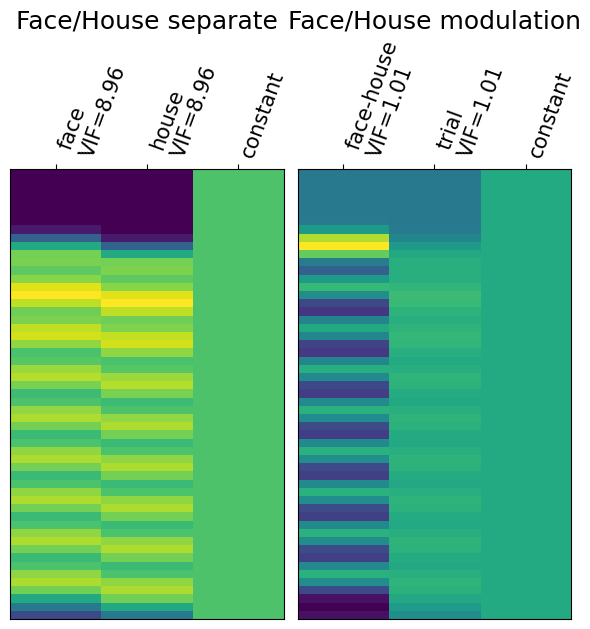

In [ ]:
name_left = 'Face/House separate'
name_right = 'Face/House modulation'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/face_house_orth_des.pdf'
make_desplot(
    original_design_matrix,
    modulated_design_matrix,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [ ]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 2
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)

frame_times = np.arange(0, onset_max + 10, 1)
des_with_deriv = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_separate,
    hrf_model='spm + derivative',
    drift_model=None,
)

des_no_deriv = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)

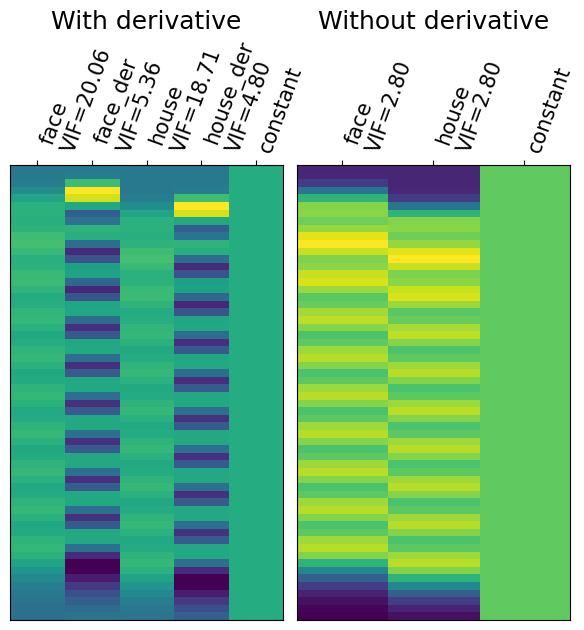

In [ ]:
name_left = 'With derivative'
name_right = 'Without derivative'

des_with_deriv.columns = des_with_deriv.columns.str.replace(
    'derivative', 'der'
)

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/with_without_deriv_des.pdf'
make_desplot(
    des_with_deriv,
    des_no_deriv,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [ ]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 0.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cueprobe = np.array(['cue+probe'] * len(onsets_a))
duration_cue_probe = np.ones_like(onsets_a) * 2.5

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_cue_probe_together = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cueprobe,
        'duration': duration_cue_probe,
    }
)

frame_times = np.arange(0, onset_max + 10, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_cueprobe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_together,
    hrf_model='spm',
    drift_model=None,
)

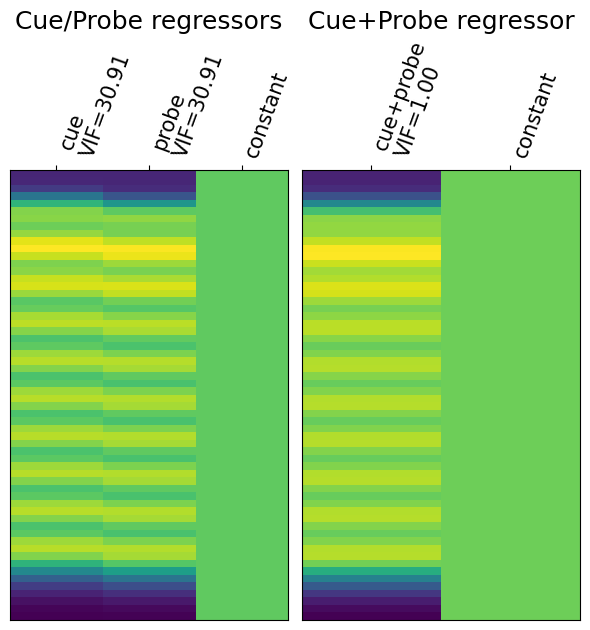

In [ ]:
name_left = 'Cue/Probe regressors'
name_right = 'Cue+Probe regressor'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/cue_probe_combined_des.pdf'
make_desplot(
    des_cue_and_probe,
    des_cueprobe,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [ ]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 1.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
duration_impulse = np.ones_like(onsets) * 0.01

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_impulse = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration_impulse}
)

frame_times = np.arange(0, onset_max + 10, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_impulse = make_first_level_design_matrix(
    frame_times, events=events_impulse, hrf_model='spm', drift_model=None
)

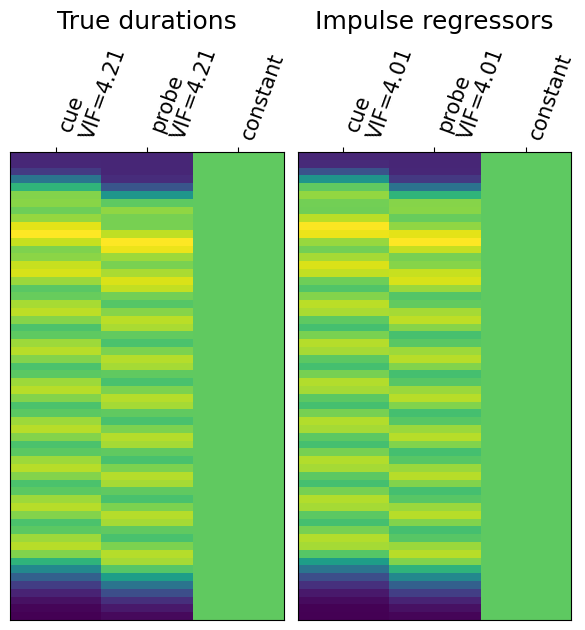

In [ ]:
name_left = 'True durations'
name_right = 'Impulse regressors'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/impulse_des.pdf'
make_desplot(
    des_cue_and_probe,
    des_impulse,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [ ]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 0.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cue = np.array(['cue'] * len(onsets_a))
duration_cue = np.ones_like(onsets_a) * 1

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_no_probe = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cueprobe,
        'duration': duration_cue_probe,
    }
)

frame_times = np.arange(0, onset_max + 10, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_no_probe = make_first_level_design_matrix(
    frame_times, events=events_no_probe, hrf_model='spm', drift_model=None
)

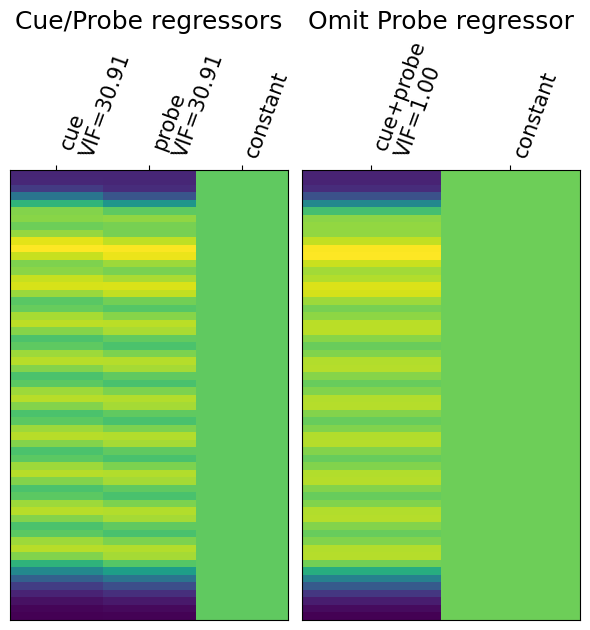

In [ ]:
name_left = 'Cue/Probe regressors'
name_right = 'Omit Probe regressor'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/omit_probe_des.pdf'
make_desplot(
    des_cue_and_probe,
    des_no_probe,
    name_left,
    name_right,
    figure_path=figure_path,
)